In [1]:
import torch
import matplotlib.pyplot as plt

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [2]:
# learn texture from image
from Renderer import Renderer
verts_T_paths = ['data/verts_T/0002_c1s2_064446_01.pkl']
tm_paths = ['data/meta/default_texture.jpg']
image_path = 'data/images/0002_c1s2_064446_01.jpg'

renderer = Renderer(device=device)
renderer.load_inputs(verts_T_paths,tm_paths = tm_paths)

In [3]:
images = renderer.render()
# mask = renderer.binary_mask(images,threshold=0.5)

In [4]:
images.sum().backward()

In [5]:
renderer.verts.grad

tensor([[[ 6.6604e+00,  1.6466e+02, -3.0820e+00],
         [ 2.5044e+01, -6.6184e+00,  1.5895e-01],
         [ 4.9234e+00, -6.4527e+00,  1.2198e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]])

# utils

In [8]:
from utils import remove_background

image_path = "data/images/0002_c1s2_064446_01.jpg"
seg_mask_path = "data/seg/0002_c1s2_064446_01.png" 
img = remove_background(image_path,seg_mask_path)

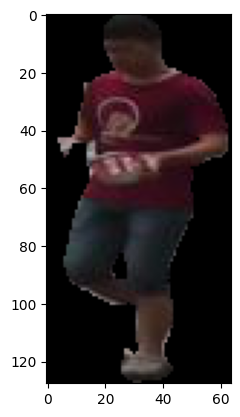

In [9]:
plt.imshow(img)

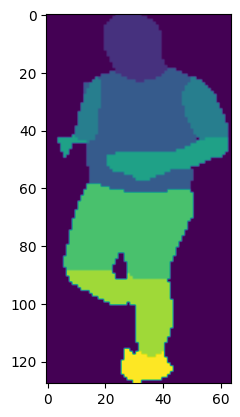

In [10]:
seg = plt.imread(seg_mask_path)
plt.imshow(seg)

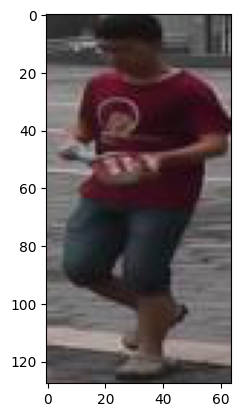

In [ ]:
img = plt.imread(image_path)
plt.imshow(img)